# Stationarity and Autocorrelation

## What we will accomplish

In this notebook we will:
- Motivate the study of stationary time series
- Define the concepts of:
    - Strict stationarity
    - Weak stationarity
- Learn about autocorrelation,
- Plot autocorrelation at different lags

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
set_style("whitegrid")

## Motivation

Let's do a more detailed analysis of the sunspot dataset.

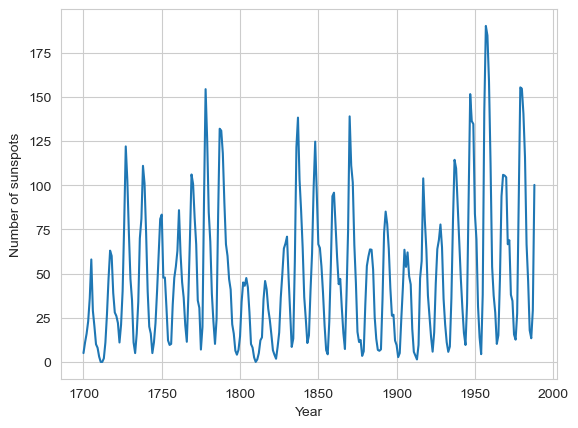

In [2]:
df = pd.read_csv('../../data/sunspot.year.csv', index_col=[0])
df.columns = ['year', 'sunspots']

plt.plot(df.year, df.sunspots)
plt.xlabel('Year')
plt.ylabel('Number of sunspots')
plt.show()

As mentioned previously we can see a positive correlation between the number of sunspots this year and last year:

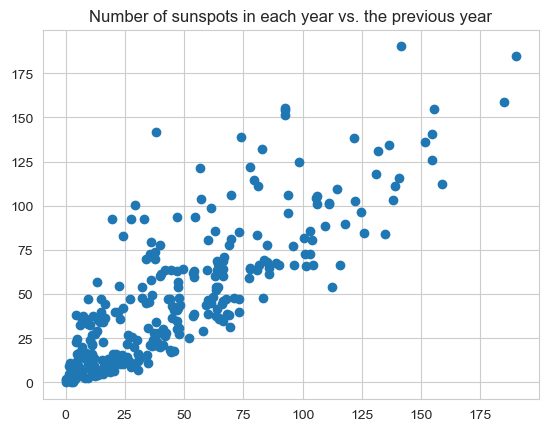

In [3]:
plt.scatter(df.sunspots.shift(1).iloc[1:], df.sunspots.iloc[1:])
plt.title("Number of sunspots in each year vs. the previous year")
plt.show()

It would also be interesting to understand the relationship between $y_t$, $y_{t-1}$ and $y_{t-2}$.

Let's define a helper function to let us fit the regressions of the form 

$$
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \dots  + \beta_p y_{t - p} + \epsilon_t
$$

where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$

Note:  These are called **autoregressive models** since we are "regressing the time series on itself".

In [4]:
def design_matrix_of_lags(ts, num_lags):
    '''
    Inputs
        ts: A numpy array of size (n,) representing a time series
        num_lags: The number of lags to include in the resulting design matrix

    Outputs
        X: A numpy array of size (n - num_lags, num_lags). 
            The first column is lag 1, second column is lag 2, etc 
        y: The time series starting at entry num_lags
    '''
    n = len(ts)
    X = np.zeros(shape = (n - num_lags, num_lags))
    for i in range(num_lags):
        X[:, i] = ts[i:i + n - num_lags]
    y =  ts[num_lags:]
    return (X,y)

In [5]:
# Example of the function at work
design_matrix_of_lags([1,2,3,4,5,6,7,8], 3)

(array([[1., 2., 3.],
        [2., 3., 4.],
        [3., 4., 5.],
        [4., 5., 6.],
        [5., 6., 7.]]),
 [4, 5, 6, 7, 8])

We now fit a model model:

$$
y_t = \beta_0 y_{t-1} + \beta_1 y_{t-2}  + \epsilon\\
$$

In [21]:
from sklearn.linear_model import LinearRegression

lr_lag_2 = LinearRegression()

lr_lag_1.fit(X_lag_1, y_lag_1)

lr_lag_2.fit(X_lag_2, y_lag_2)

# Alternatively you could use the "splat operator" * for variable unpacking instead. 
# lr_lag_2.fit(*design_matrix_of_lags(df.sunspots, 2))

LinearRegression()

In [22]:
lr_lag_2.coef_

array([-0.69256317,  1.39000364])

Auto-regressive models like this one are an example of **stationary time series models**.

## Stationarity

When modeling time series we shouldn't assume that samples are independent and identically distributed.  Stationarity is the next best thing:

We say that a time series $\left\lbrace y_t  \right\rbrace$ is <i>strictly stationary</i> if the joint probability distribution of $y_{t_1}, y_{t_2}, \dots y_{t_n}$ is equal to that of $y_{t_1 + \tau}, y_{t_2 + \tau}, \dots y_{t_n + \tau}$. for any $t_1, \dots, t_n, \tau, n$. This implies that the joint distribution only depends on the intervals between $t_1, \dots, t_n$ and in particular if $n=1$:

$$
E(y_t) =  \mu, \ \ \ \text{Var}(y_t) = \sigma^2
$$

are not functions of $t$. Further if $n=2$ the joint distribution of $y_{t_1}$ and $y_{t_2}$ only depends on $(t_2 - t_1)$, which is called the <i>lag</i> between $t_1$ and $t_2$.

Strict stationarity is quite restrictive and we more often define a weaker sense of <i>stationarity</i>.

We will say that a time series is **covariance stationary** if:

$$
E(y_t) = \mu, \ \text{ and } \ \text{Cov}\left( y_t, y_{t+\tau} \right) = \gamma(\tau).
$$

This is also known as "weak sense stationary", "wide sense stationary" or just "stationary".

### Examples

Some examples of a stationary time series are:
- White noise, 
- A moving average process, i.e. 

$$
y_{t} = \beta_0 \epsilon_{t} + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + \dots + \beta_q \epsilon_{t-q}
$$
- An autoregressive process, i.e.

$$
y_{t} = \beta_0 y_{t-1} + \beta_1 y_{t-2} + \beta_2 y_{t-3} + \dots + \beta_q y_{t-q-1} + \epsilon_t
$$

Note:  These last two examples are only stationary for certain values of $\beta$.

## Autocorrelation

The <i>autocorrelation</i> of a time series is essentially the correlation of that time series with its future observations placed at different lags. In particular, the autocorrelation of a time series at lag $k$ is given by:

$$
\begin{align*}
r_k &= 
\operatorname{Corr}(y_{t+k},y_t)\\
&=\frac{\operatorname{Cov}(y_{t+k},y_{t})}{\operatorname{StDev}(y_{t+k})\operatorname{StDev}(y_{t})} \\
\end{align*}
$$

If the time series is stationary, then $\operatorname{StDev}(y_{t+k}) = \operatorname{StDev}(y_{t})$, so their product is just the variance $\operatorname{Var}(y_t)$.  In this case we can use

$$
\hat{r}_k = \frac{\displaystyle\sum_{t=1}^{n-k} \left(y_t - \overline{y}\right) \left(y_{t+k} - \overline{y} \right)}{\displaystyle\sum_{t=1}^n \left(y_t - \overline{y}\right)^2}
$$

as the sample statistic where $n$ is the last observation of the time series.

### Correlogram

We commonly plot this as a way to understand the autocorrelation structure. This can be done with `statsmodels` `plot_acf` function, <a href="https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html</a>.

#### Example: White noise

In [14]:
import statsmodels.api as sm

In [15]:
## make some data
## white noise
np.random.seed(440)
series = np.random.random(100) - .5

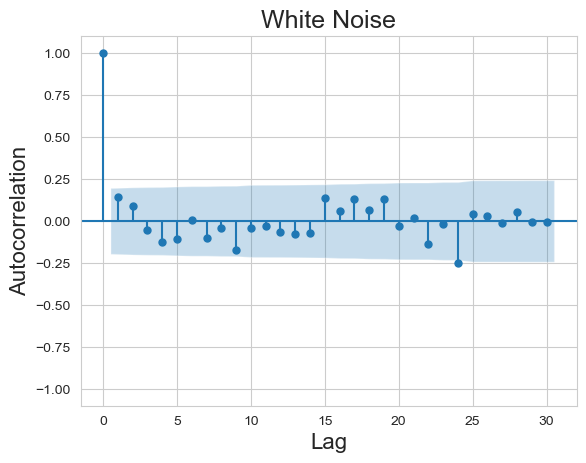

In [16]:
## first put in the time series
## then set how many lags you want to consider
## the default is lags=30
sm.graphics.tsa.plot_acf(series,
                            lags = 30)

plt.title('White Noise', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

The autocorrelation of every time series will be $1$ at lag $0$. For stationary series, like white noise, we expect to seem some low autocorrelation for small lags. Autocorrelation should then tend to randomly bubble around getting closer and closer to $0$ as the lag increases.

#### Example: Data with a trend

If your data exhibits a trend it is <b>not</b> stationary. Here is an example of what the associated correlogram may look like for data with a trend.

In [17]:
goog = pd.read_csv("../../data/google_stock.csv", parse_dates=['date'])

In [25]:
goog

,date,closing_price
0,2004-08-19,49.982655
1,2004-08-20,53.952770
2,2004-08-23,54.495735
3,2004-08-24,52.239197
4,2004-08-25,52.802086
...,...,...
4427,2022-03-21,2729.570068
4428,2022-03-22,2805.550049
4429,2022-03-23,2770.070068
4430,2022-03-24,2826.239990


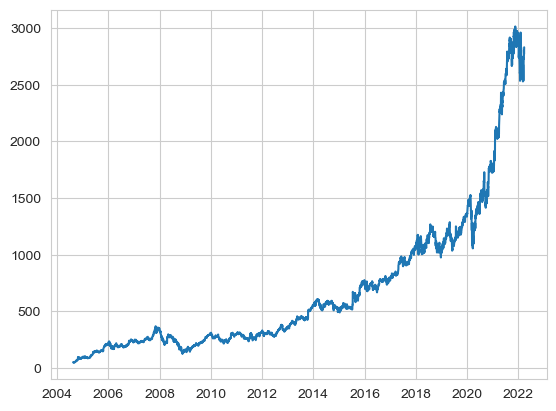

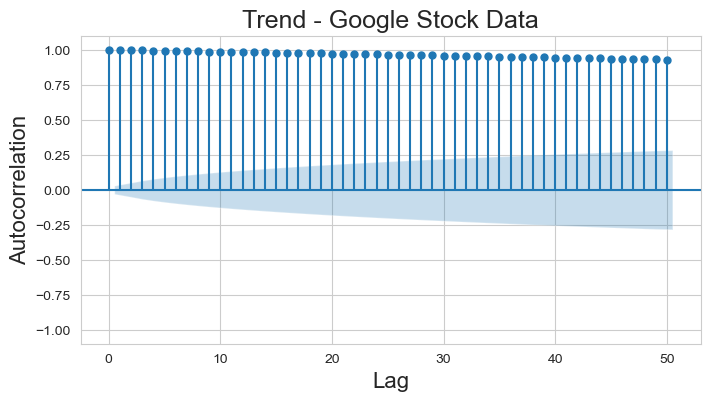

In [27]:
plt.plot(goog.date, goog.closing_price)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

sm.graphics.tsa.plot_acf(goog.closing_price.values,
                            lags = 50,
                            ax = ax)

plt.title('Trend - Google Stock Data', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

If you see a correlogram that has high (in magnitude) autocorrelation values over a long range of lags this is indicative of a time series that is not stationary. Importantly, seing a time series with a correlogram like this does not necessarily imply that the time series in question exhibits a trend, just that it is not stationary.

<i>We will see how we may turn this into a stationary series below</i>.

#### Example: Data with seasonality

If your data exhibits seasonality it is <b>not</b> stationary. Here is an example that demonstrates what a seasonal correlogram may look like.

In [19]:
flu = pd.read_csv("../../data/us_flu_1928_1948.csv", parse_dates=['date'])

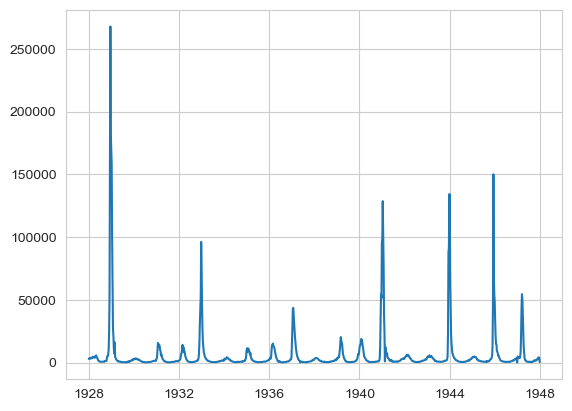

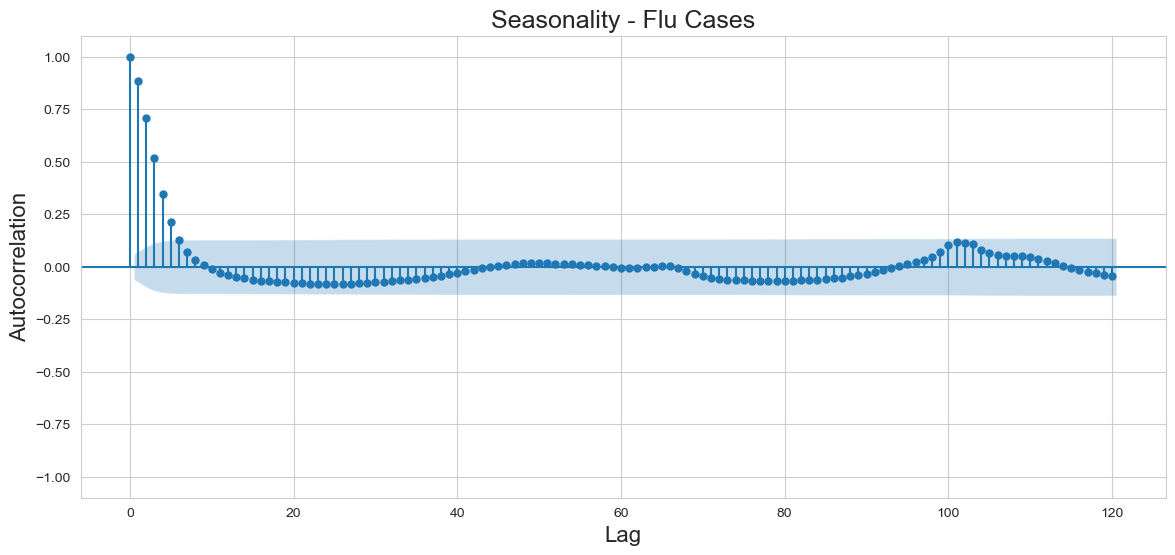

In [29]:
plt.plot(flu.date, flu.cases)


fig, ax = plt.subplots(1, 1, figsize=(14,6))

sm.graphics.tsa.plot_acf(flu.cases,
                            lags=120,
                            ax=ax)

plt.title('Seasonality - Flu Cases', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

Time series with seasonality often produce sinusoidal autocorrelation plots. Similar to our above point, seeing sinusoidal autocorrelation may hint at seasonality but is not always proof that a time series exhibits seasonality. However, it does imply that the time series is probably not stationary.

### Statistical tests

There are formal statistical tests that you can perform to examine if a time series whether a time series is stationary, but we will not cover them. Interested parties may wish to start here:
- <a href="https://en.wikipedia.org/wiki/Unit_root_test">https://en.wikipedia.org/wiki/Unit_root_test</a> and
- <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test</a>.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)